# Week 09

Unsupervised Learning: PCA and Dimensionality Reduction

## Setup

Run the following 2 cells to import all necessary libraries and helpers for this week's exercises

In [1]:
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/data_utils.py
!wget -q https://github.com/PSAM-5020-2025S-A/5020-utils/raw/main/src/image_utils.py

!wget -qO- https://github.com/PSAM-5020-2025S-A/5020-utils/releases/latest/download/att-faces.tar.gz | tar xz

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import PIL.Image as PImage

from sklearn.model_selection import train_test_split

from data_utils import PCA, RandomForestClassifier, StandardScaler
from data_utils import KMeansClustering
from data_utils import object_from_json_url, classification_error, display_confusion_matrix

from image_utils import get_pixels, make_image

## More Unsupervised Learning

### Dimensionality Reduction

A few homeworks ago we looked at an image classification exercise and we saw that creating image filters by hand and selecting which features to look at can be a very laborious and complex process. Let's now combine what we learned about data normalization, distances, and learning algorithms to try to create a better image classification system.

Consider the following image that is $4$ pixels wide by $4$ pixels high, it has a total of $16$ pixels:

<img src="./imgs/pixdim-00.jpg" height="200px" />

We can think of these $16$ pixels as the features of the image, and if we had a dataset of images of this size, we can think of the rows in this dataset as our different images and then the columns being the $16$ values for each of the pixels of those images.

And the same is true for a dataset that has images that are $256$ by $256$ pixels:

<img src="./imgs/pixdim-01.jpg" height="200px" />

We would just have as many rows as we have images, and each of those rows would have $65,536$ columns/features, one for each of its pixels.

We might be tempted now to develop some kind of method that uses $L2$ distances or cosine similarities to classify images by finding similarities between their pixel content. And that might work sometimes, but consider that computing the $L2$ distance between $2$ of our $256$ x $256$ pixel images would require squaring over $65000$ terms... and if we look at the black and white $4$ x $4$ images below, it's not so clear that subtracting raw pixel values would give us any indication of similarity:

<img src="./imgs/pixdiff.jpg" height="200px" />

The difference between the first image and the second image is of $8$ pixels. The difference between the first and third image is also of $8$ pixels, while the difference between the second and third image is of $16$ pixels, even though they're more similar. The same could be calculated for the last two pictures and the first.

What we want to do instead is something called **_dimensionality reduction_**, where we turn those $65,000$ columns of pixel values into a smaller number of columns that represent more meaningful and complex information about the images.

### Projection

One way of reducing the dimensions of our dataset is by doing something called **_feature projection_**, which is very simple to perform and understand. We did this when we dropped features from the wine dataset last week.

**_Feature Projection_** is when we just drop the columns in our dataset that we think are less important. The results of doing this can be seen in the following two images:

<img src="./imgs/dimredproj-00.jpg" height="350px" />

On the left side we have a graph of our data set in two dimensions. On the right, at the very bottom, we've projected all of those points straight down onto the x-axis by just ignoring their $y$ components.

On next image we can see what the problem with doing that might be. Points that are actually further apart in our full dataset will seem closer once projected to a lower dimension like this, and points that are close together in $2D$ space can seem further apart in $1D$ space.

<img src="./imgs/dimredproj-03.jpg" height="350px" />

### Space-Filling Curves

Another way of reducing dimensions is by using **_space-filling curves_**, like the [Hilbert curve](https://en.wikipedia.org/wiki/Hilbert_curve) or [Z-order curves](https://en.wikipedia.org/wiki/Z-order_curve).

These functions reorder our data by tracing a curvy path between all the points in our dataset. If we look at the following images:

<img src="./imgs/dimredcurve-00.jpg" height="350px" />

The image on the left again shows our $2D$ data points graphed on a plane. On the right, we've drawn a line that connects all of our points by starting with a point on the lower-left side of the graph and then connecting to the nearest point, and then the next nearest point and so on and so on. In the end we have the light-blue line that connects and re-orders all of our $2D$ points into a $1D$ line.

The problem with this method is that **_space-filling curves_** still have some discontinuities, or jumps, which might result in the same problem as **_projection_**, where closer points become further apart after transformation and vice-versa.

### Principal Component Analysis

One final way of reducing the dimensions in our dataset is by doing something called **_principal component analysis_** or **_PCA_**. This is a kind of unsupervised learning algorithm that looks at all of our original data and tries to figure out the directions in which it spreads out the most.

<img src="./imgs/dimredpca-00.jpg" height="350px" />

Again, on the left we have the original $2D$ data on a plane. On the right we see the original data with a line that represents the direction in which the data seems to spread.

**_PCA_** is kind of, sort of, like doing **_Linear Regression_** in a special manner, and finding many lines-of-best-fit, but with special properties. We can think of these new lines as new axes that we re-orient our data around, and instead of having the $x$ axis and the $y$ axis we'll have $2$ new axes, one in the direction that captures the most variation in our data, and another in a perpendicular direction, that captures less of the variation in our data, like below:

<img src="./imgs/dimredpca-03.jpg" height="350px" />

But, wait ! If we have $N$ dimensions to begin with and we end up with these $N$ lines/axis/features, isn't it the same as before ? We still have $N$ dimensions to deal with!

Yes, but the thing about the **_PCA_** axes is that these lines, or, principal components, are actually ordered by importance, so the very first principal component is the one that captures most of the variation in our data, the second one captures the second most amount of variation in our data, the third one the third most, and so on and so on...

What we want to do after we compute the principal components of our dataset is perform a **_projection_** and chop off most of the new dimensions. Most of the information about our data will be captured by the first couple of principal components, so we can now project our data onto a few of these new axes and they'll retain most of the information about our data.

<img src="./imgs/dimredpca-02.jpg" height="350px" />

In the $2D$ case above if we only consider the first principal component and project our data onto that blue line we retain most of the information about the relative distances between the points in our dataset, but since they're all projected onto a line, they can be represented by just $1$ feature/value. In the end we were able to reduce our data from having $2$ variables in the $XY$ plane to just having one variable in the direction of the first principal component.

Let's look at some examples.

#### PCA in 3D

Let's reload the `ANSUR` data and look only at the features about hands. We'll use PCA to reduce the dimensions of this subset of our data from $3$ to $1$ dimension.

We'll start by looking at the hand data using $3$ features because $3$ is something we can plot using $3D$ graphs.

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


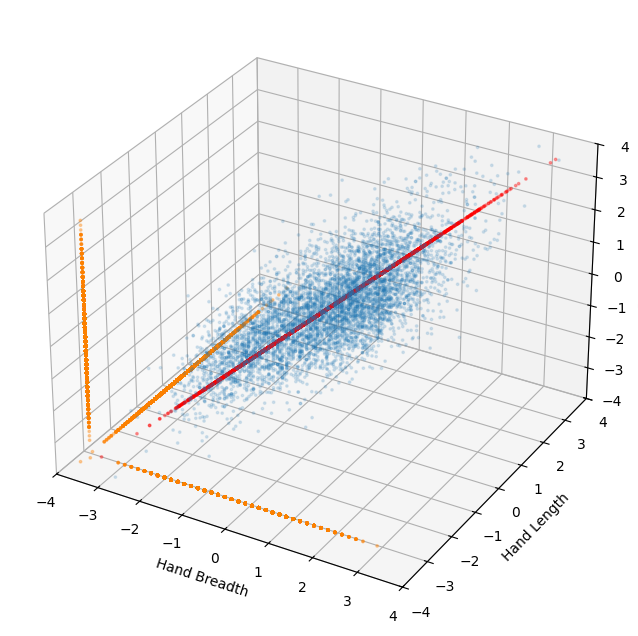

In [ ]:
ANSUR_FILE = "https://raw.githubusercontent.com/PSAM-5020-2025S-A/5020-utils/main/datasets/json/ansur.json"

ansur_data = object_from_json_url(ANSUR_FILE)

ansur_df = pd.json_normalize(ansur_data)
display(ansur_df.head())

hand_df = ansur_df[["hand.breadth", "hand.length", "hand.palm"]]

# scale and pca objects
hand_mss = StandardScaler()
hand_pca = PCA(n_components=1)

# perform scaling and pca
hand_df = hand_mss.fit_transform(hand_df)
hand_pca_df = hand_pca.fit_transform(hand_df)

# project from 1 PCA back to original 3 dimensions
hand_pca_i_df = hand_pca.inverse_transform(hand_pca_df)

# plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

# Original 3D data in x,y,z space
ax.scatter(hand_df["hand.breadth"], hand_df["hand.length"], hand_df["hand.palm"], s=3, alpha=0.15)

# Original data projected onto each of the 3 axis
ax.scatter(hand_df["hand.breadth"], [-3.5]*len(hand_df["hand.length"]), [-3.5]*len(hand_df["hand.palm"]), s=3, c='#ff8000', alpha=0.333)
ax.scatter([-3.5]*len(hand_df["hand.breadth"]), hand_df["hand.length"], [-3.5]*len(hand_df["hand.palm"]), s=3, c='#ff8000', alpha=0.333)
ax.scatter([-3.5]*len(hand_df["hand.breadth"]), [-3.5]*len(ansur_df["hand.length"]), hand_df["hand.palm"], s=3, c='#ff8000', alpha=0.333)

# Data projected onto the first principal component
ax.scatter(hand_pca_i_df["hand.breadth"], hand_pca_i_df["hand.length"], hand_pca_i_df["hand.palm"], s=3, c='r', alpha=0.333)

# Axis limits
ax.set_xlim((-4, 4))
ax.set_ylim((-4, 4))
ax.set_zlim((-4, 4))

# Axis Labels
ax.set_xlabel("Hand Breadth")
ax.set_ylabel("Hand Length")
ax.set_zlabel("Palm Length")

plt.show()



In [ ]:
hand_df # 3D data

,hand.breadth,hand.length,hand.palm
0,-1.091728,-0.631450,-0.829835
1,0.324677,-0.457501,0.011265
2,-0.147458,-0.805398,-1.530751
3,1.583704,1.021064,1.413097
4,0.796812,0.412243,-0.128919
...,...,...,...
5595,-0.776971,-0.979347,-2.231667
5596,1.111569,0.412243,1.132731
5597,0.482055,-0.892373,-0.269102
5598,0.796812,0.499217,0.151448


In [ ]:
hand_pca_df # 1D data

,PC0
0,-1.459981
1,-0.090415
2,-1.462098
3,2.303816
4,0.604654
...,...
5595,-2.320909
5596,1.517664
5597,-0.429796
5598,0.821517


In [ ]:
hand_pca.components # the principal component

array([[0.54435316, 0.59841616, 0.58785861]])

The graph above shows the original data for the `hand.breadth`, `hand.length` and `hand.palm` features in blue.

The orange points show the data projected onto the different axis. It is $1$ dimensional, meaning that in each of those cases we've completely ignored two features.

The red points show our data projected onto the first principal component.

If we call the `pca.explained_variance()` function we can see how much of our data's information has been retained.

In [13]:
hand_pca.explained_variance() # 1 component explains 82.6% of the variance

np.float64(0.826919139848481)

#### PCA in all dimensions

What if we reduce all of our features to just $1$? How much of the data's information is kept?

If we want to keep $80\%$ of our data's variance, how many components should our PCA use?

No need to plot anything, just run pca a few times and look at its `explained_variance`.

In [ ]:
## Repeat above process, using all of the original features, except gender
mss = StandardScaler()
ansur_df = pd.json_normalize(ansur_data).drop(columns=["gender"])
ansur_df = mss.fit_transform(ansur_df)

## TODO: get explained_variance() for n_components=1
mpca = PCA(n_components=5)

pca_df = mpca.fit_transform(ansur_df)

## TODO: find n_components for explained_variance >= 0.80
print(mpca.explained_variance()) # 5 components explain 80% of the variance, target at least 80%, change no. of components if neccessary

0.8179058590523424


### Interpretation

It takes more than $3$ components to keep $80\%$ of the information from our data. This isn't something we can easily plot to compare to the distribution of the original $14$ features.

We can plot the first $2$ and first $3$ principle components, but after that we just have to trust the `explained_variance` number.

#### More PCA in Multiple Dimensions

The above exercises are good for us to start building intuition about PCA, but even though we can perform PCA and reduce our features from $15$ to $5$ or $6$ principal components while retaining most of the variation in our data, it gets hard to visualize the effects of these transformations.

Let's use images. We'll load images with about $10\text{,}000$ pixels/features, and perform PCA to represent them using only $10$ components. Then we'll remap our $10$ components for each image back to $10\text{,}000$ pixels to look at the effects of **_compressing_** our data like this.

#### PCA on Images

Let's load all of the images inside the `data/image/att-faces/` directory. These images are in sub-directories that specify the `id` of the person in the image: `s0` is `subject 0`, `s1` is `subject 1`, and so on.

We'll keep track of these ids and create numeric labels for them as we read the data from the images.

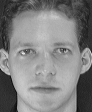

In [17]:
# lists for keeping track of image pixel lists, subject numeric id and subject label
face_pixels = []
face_ids = []
id2label = []

# 40 directories
for l in range(1, 41):
  id2label.append(f"s{l}")
  # 10 images per directory
  for i in range(1, 11):
    mimg = PImage.open(f"./data/image/att-faces/s{l}/{i}.pgm")
    face_pixels.append(get_pixels(mimg))
    face_ids.append(l)

# display first image
display(make_image(face_pixels[0], width=92))

In [18]:
# print len of lists to make sure sizes match
print(len(face_pixels), len(face_ids))

# check number of labels matches number of directories
print(len(id2label))

# check how many pixels per image and look at first 10 pixel values
print(len(face_pixels[0]), face_pixels[0][:10])

400 400
40
10304 [48, 49, 45, 47, 49, 57, 39, 42, 53, 49]


These look ok. There's only one color value per pixel since these are grayscale images.

#### Run PCA

We can run PCA directly on these lists of pixels. We don't even have to scale the data because we know the pixel values are all between $0$ and $255$ for greyscale images.

In [19]:
# run pca and get first 10 PCs
pca = PCA(n_components=10)
faces_df = pca.fit_transform(face_pixels)

# put id values in DataFrame for classification later
faces_df["id"] = face_ids

display(faces_df.head())

print(pca.explained_variance())

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,id
0,1531.176049,1072.181267,-1867.025755,261.784190,689.919478,-123.790310,424.219495,-377.532775,-439.388036,-1032.104276,1
1,2975.896454,759.883085,461.811631,1206.322578,2506.667117,384.236079,1230.076383,324.482566,-386.243131,73.979917,1
2,2696.449220,380.515753,-1004.961866,-31.708233,1029.603741,-1081.148766,463.321911,237.595006,-1116.761218,-821.224524,1
3,3242.390090,1162.888290,225.102672,2717.875592,-21.034553,-820.926435,-678.184100,-963.427566,485.968925,-886.562985,1
4,3644.615759,808.845852,-116.302255,2126.586985,214.951598,-461.790159,535.880455,206.397263,106.322265,-113.549610,1


0.5995185869332752


#### Interpretation

Our PCA-transformed data retained about $60\%$ of the information from the original data.

Our `DataFrame` now is expressed in terms of the first $10$ principal components of our data. The values for these new features are all over the place, and don't represent pixel colors anymore. They represent our data in a more _abstract_, _latent_, space. It's latent because the information is there, it exists, but it's sort of waiting to be transformed back into physical values and, in this case, visualized as pixels.

This `PCA` transformation was able to compress our data and reduce the number of dimensions for each of our images from $10\text{,}304$ to $10$ ! That's a reduction factor of $1000$ ! We could start thinking about doing clustering or classification by measuring distances between these images because now they only have $10$ dimensions, and each of the dimensions represents a combination of color information, not just one pixel.

But, let's visualize our new compressed images first.

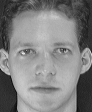

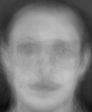

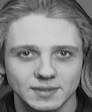

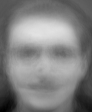

In [20]:
# Reconstruction: un-projects the data from PCA space into pixel space
pca_pixels = pca.inverse_transform(faces_df)

display(make_image(face_pixels[0], width=92))
display(make_image(pca_pixels.loc[0], width=92))

display(make_image(face_pixels[110], width=92))
display(make_image(pca_pixels.loc[110], width=92))

### 🤔

We did lose $40\%$ of the detail of our data when we transformed it into `PCA` space.

These don't look too good at first, but they also don't look that bad. Given how regular all of the images are, maybe this level of detail is all that is needed to do any kind of classification or clustering.

#### More components

Re-run PCA with $20$ and $120$ components. Don't worry about printing the `DataFrame`, but reconstruct some of the images like we did in the cell above.

What is the effect of keeping more components in our PCA?

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,id
0,1531.176049,1072.181267,-1867.025753,261.784165,689.919437,-123.791477,424.223556,-377.547360,-439.429134,-1032.160780,...,160.601913,-179.250086,-261.130221,-106.710922,80.570373,89.632690,728.908171,-154.570352,259.959395,1
1,2975.896454,759.883085,461.811665,1206.322302,2506.667278,384.233975,1230.000642,324.483608,-385.945805,73.071762,...,291.756961,-123.788217,1000.383657,464.505557,325.923554,293.431098,318.441059,681.253305,558.630770,1
2,2696.449220,380.515753,-1004.961840,-31.708452,1029.603821,-1081.150772,463.270414,237.585308,-1116.531550,-821.978421,...,-569.353846,454.907074,101.827948,-469.701689,-581.354777,423.459553,431.146985,-113.146262,361.988782,1
3,3242.390090,1162.888290,225.102682,2717.875540,-21.034456,-820.926332,-678.218045,-963.411225,486.023570,-886.780844,...,-202.890656,-518.750074,-142.808886,-480.961122,-341.591520,-597.929308,-216.525138,-199.139346,90.113648,1
4,3644.615759,808.845852,-116.302230,2126.586809,214.951774,-461.790848,535.812533,206.416276,106.529980,-114.165893,...,168.314147,-461.531508,817.399937,48.450706,524.930481,34.806076,66.017240,890.773524,239.718855,1


0.7001445859569417


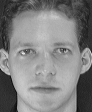

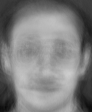

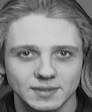

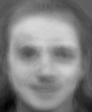

In [22]:
## TODO: reconstruct images using 20 component PCA
pca = PCA(n_components=20)
faces_df = pca.fit_transform(face_pixels)


# put id values in DataFrame for classification later
faces_df["id"] = face_ids

display(faces_df.head())

print(pca.explained_variance())


pca_pixels = pca.inverse_transform(faces_df)

display(make_image(face_pixels[0], width=92))
display(make_image(pca_pixels.loc[0], width=92))

display(make_image(face_pixels[110], width=92))
display(make_image(pca_pixels.loc[110], width=92))

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,id
0,1531.176049,1072.181267,-1867.025754,261.784166,689.919436,-123.791463,424.224110,-377.547603,-439.430091,-1032.163102,...,-179.794755,-86.139226,-77.520266,-43.213632,-35.269735,-74.909377,45.736147,-147.696820,-272.792365,1
1,2975.896454,759.883085,461.811665,1206.322301,2506.667274,384.234016,1230.000331,324.482959,-385.946089,73.073266,...,-107.217276,105.037594,11.320031,-51.069467,13.727222,144.399927,39.431940,48.447350,21.323434,1
2,2696.449220,380.515753,-1004.961840,-31.708451,1029.603818,-1081.150756,463.271813,237.583672,-1116.531136,-821.986424,...,-20.999771,-5.459994,-95.270602,2.908374,0.284429,-360.774848,1.789839,55.268822,76.296694,1
3,3242.390090,1162.888290,225.102682,2717.875540,-21.034456,-820.926372,-678.218133,-963.411337,486.021808,-886.779048,...,-69.467414,84.714686,75.551780,110.792480,-24.972863,-129.257157,-18.308396,113.177849,-1.786410,1
4,3644.615759,808.845852,-116.302231,2126.586808,214.951770,-461.790801,535.812867,206.414792,106.530352,-114.167752,...,-238.573279,-18.562660,-108.316009,-72.375540,-120.876483,-80.776560,-71.766400,-58.241483,-180.996964,1


0.9074037115669736


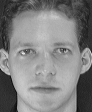

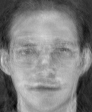

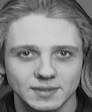

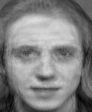

In [23]:
## TODO: reconstruct images using 120 component PCAs
pca = PCA(n_components=120)
faces_df = pca.fit_transform(face_pixels)


# put id values in DataFrame for classification later
faces_df["id"] = face_ids

display(faces_df.head())

print(pca.explained_variance())


pca_pixels = pca.inverse_transform(faces_df)

display(make_image(face_pixels[0], width=92))
display(make_image(pca_pixels.loc[0], width=92))

display(make_image(face_pixels[110], width=92))
display(make_image(pca_pixels.loc[110], width=92))

### Common features

One way to think about how `PCA` compresses our features, is to imagine that it can factor out common elements between features that are strongly correlated. For numerical data, those common factors are just parameters to a series of multiplications. Boring.

With images, the common factors between our features can actually be seen because our features represent pixels.

We can iterate over the `PCA` factors (or, `components`) and display them as images. We just have to scale them to pixel range.

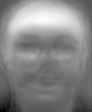

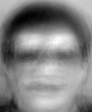

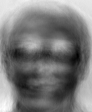

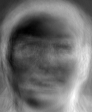

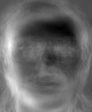

In [24]:
for comp in pca.components[:5]:
  minVal = comp.min()
  maxVal = comp.max()
  # manually mapping to [0, 1]
  pxs01 = (comp - minVal) / (maxVal - minVal)
  # mapping to [0, 255]
  pxs = [255 * p for p in pxs01]
  display(make_image(pxs, width=92))

### Interpretation

Having $10$ components in our transformation means having $10$ of these "common" faces and $10$ features in our transformed dataset. The original faces are reconstructed (with error) by multiplying the $10$ features in the transformed dataset by their corresponding face, so `PC0` with the first face, `PC1` with the second face, and so on, and then adding those results.

These top-5 "common" faces will always be the same for this dataset, independent of the number of components we keep in our `PCA` transformation. 

Adding components to our transformation just increases the number of these "common" faces that get extracted, but their order doesn't change.

#### Back to $10$ components

Let's go back to just using $10$ PCs and see how the first $100$ images are distributed in the first $2$ dimensions.

0.5995185940320701


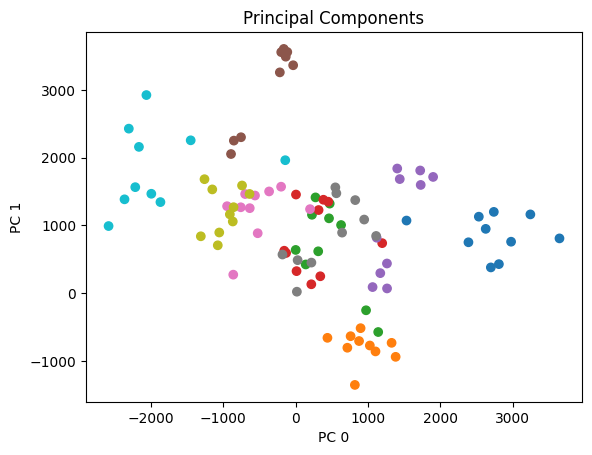

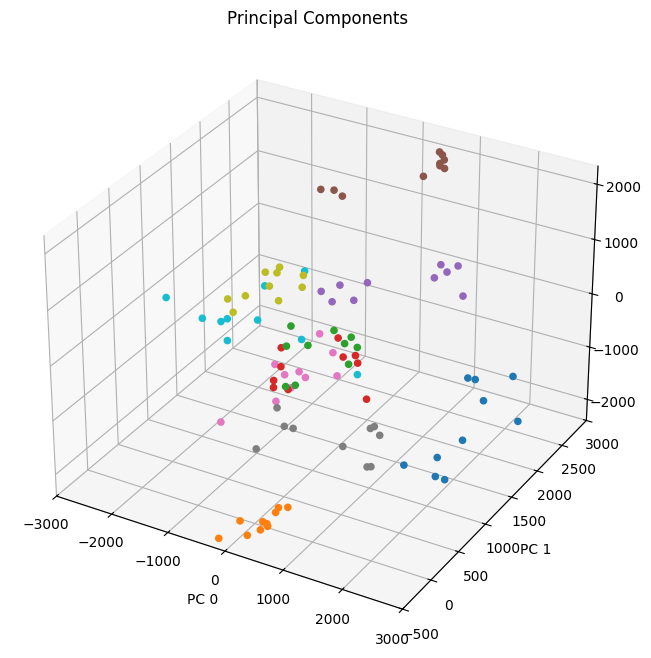

In [25]:
# run pca and get first 10 PCs
pca = PCA(n_components=10)
faces_df = pca.fit_transform(face_pixels)

# put id values in DataFrame
faces_df["id"] = face_ids

print(pca.explained_variance())

# first 10 ids
x = faces_df["PC0"][:100]
y = faces_df["PC1"][:100]
z = faces_df["PC2"][:100]
c = faces_df["id"][:100]

# 2D
plt.scatter(x, y, c=c, marker='o', linestyle='', alpha=1, cmap="tab10")
plt.title("Principal Components")
plt.xlabel("PC 0")
plt.ylabel("PC 1")
plt.show()

# 3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')

ax.scatter(x, y, z, c=c, marker='o', linestyle='', alpha=1, cmap="tab10")
plt.title("Principal Components")
ax.set_xlabel("PC 0")
ax.set_ylabel("PC 1")
ax.set_ylabel("PC 1")

ax.set_xlim((-3000, 3000))
ax.set_ylim((-500, 3000))
# ax.set_zlim((-4, 4))

plt.show()

#### Interpretation

Here we are only looking at the top $2$ and $3$ dimensions of our data and we can already see some patterns/clusters.

The colors were added manually using the correct `id` for each image, so that helps to see patterns...

Now, let's run the `RandomForestClassifier` algorithm on this dataset to see if PCA dimensionality reduction can actually help prepare image datasets for classification tasks.

### PCA + Classification

We have already prepared our `DataFrame` and added a column with the numerical `id` of each image.

We can check by running `faces_df.head()`:

In [26]:
faces_df.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,id
0,1531.176049,1072.181267,-1867.025775,261.784038,689.919643,-123.788922,424.174509,-377.533749,-439.450691,-1031.734140,1
1,2975.896454,759.883085,461.811604,1206.321949,2506.668183,384.245376,1229.889593,324.540232,-386.240635,73.920160,1
2,2696.449220,380.515753,-1004.961879,-31.708644,1029.604323,-1081.144405,463.216870,237.600354,-1116.711447,-821.486118,1
3,3242.390090,1162.888290,225.102658,2717.875463,-21.034235,-820.924207,-678.226205,-963.443557,485.970114,-886.514232,1
4,3644.615759,808.845851,-116.302304,2126.586435,214.952829,-461.777981,535.716574,206.442947,106.178534,-113.262633,1


#### Separate Train and Test Data

In order to measure how well our classifier works in general, we should separate our data into $2$ subsets, one which will get used to train our model, and another that we can use to measure how well our model performs on data it hasn't seen before.

This is to avoid having our model memorize the training data, and then performing horrible on new data in the future.

We'll use the `Scikit-Learn` function `train_test_split` to split our `DataFrame` into $2$ equal datasets.

Since the split is random, the `while` loop below is just to guarantee that our test dataset has images from all subjects.

In [27]:
test_ids = []

while len(set(test_ids)) != len(id2label):
  faces_train_df, faces_test_df = train_test_split(faces_df, test_size=0.5)
  test_ids = faces_test_df["id"]

In [28]:
display(faces_train_df.head())
display(faces_test_df.head())

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,id
129,2512.921778,319.468759,1117.572769,-97.121404,-341.213164,-422.676399,370.187325,-500.835074,-640.102771,-482.687778,13
156,1019.368415,580.999392,-1563.102016,1079.351691,433.105451,564.477421,1591.309586,292.951213,-322.383693,-744.801969,16
103,875.443056,-1677.930936,-1462.402949,-1096.146093,-125.797042,-895.109426,918.208910,-195.138121,1036.952985,287.374084,11
237,-1632.405608,44.726133,-1432.377686,1072.464268,1133.038868,120.962644,-106.984639,-57.673836,-344.722025,-986.006598,24
332,-501.827518,-2848.096860,528.436017,1535.144825,1105.370148,435.851177,302.157480,484.109718,109.572165,44.622432,34


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,id
175,2397.474838,1390.692752,567.201035,-19.669309,141.723341,-71.780174,43.641611,-1006.868921,-585.389098,597.500568,18
253,1432.185763,-126.872373,1545.807493,-39.288869,-1618.630135,628.857436,-304.892778,691.929379,425.176878,553.004435,26
200,-2056.847348,-70.034000,670.138423,453.754750,-563.831909,316.456029,-398.663560,821.011058,-316.822026,148.407410,21
308,-2019.424148,428.658748,582.416212,-94.081477,-496.693929,1175.842972,-466.421929,274.901180,618.907002,-299.145910,31
137,982.486760,-2654.660388,-279.851599,-1391.435978,-522.217120,-624.565071,-312.236506,-251.204052,933.825838,-298.951902,14


#### Train Classifier

The below steps should look familiar.

We split the output feature from he rest of the features, and pass those to the `fit()` function of an instance of the `RandomForestClassifier` class.

We're not re-scaling our components/features from `PCA`, because we're assuming that any difference in the magnitude of those features is actually important information that the algorithm can use to create a model. And, `RandomForest` and `DecisionTree` classifiers tend to be a little less sensitive to scaling because of their `if`/`else` nature.

That's not always the case. Other modeling methods/algorithms might benefit from having standardized data to work with.

In [29]:
face_model = RandomForestClassifier()

train_features = faces_train_df.drop(columns=["id"])
train_ids = faces_train_df["id"]

# Create a model that classifies faces based on principal components
face_model.fit(train_features, train_ids)

## 6. Run the model on the training data
train_predicted = face_model.predict(train_features)

## 7. Measure error
classification_error(train_ids, train_predicted)

0.0

Classification Error should be close to $0$.

#### Test Data

Now we'll run the `predict()` function of our classifier on our test dataset and see how it performs.

Again, this should look familiar: we just have to remember to separate the output feature (`id`) from the other features, and then pass the list of independent features to the `predict()` function.

In [30]:
test_features = faces_test_df.drop(columns=["id"])
test_ids = faces_test_df["id"]

## 6. Run the model on the test data
test_predicted = face_model.predict(test_features)

## 7. Measure error
classification_error(test_ids, test_predicted)

0.26

#### Interpretation

The Classification Error should be close to $20\%$.

This isn't bad !

Remember, we just loaded up some unknown dataset of images, automatically reduced the number of dimensions in each image from $10\text{,}304$ to $10$ and used a basic `RandomForestClassifier()` to learn patterns on the compressed data.

We didn't have to look at pixels, we didn't have to manually filter images, we didn't even have to guess which features to keep. PCA helped with all of this.

#### Confusion Matrix

We can run the following cell to print a **_Confusion Matrix_** for our model. This is a graph that shows how well our model performed on each class of our data.

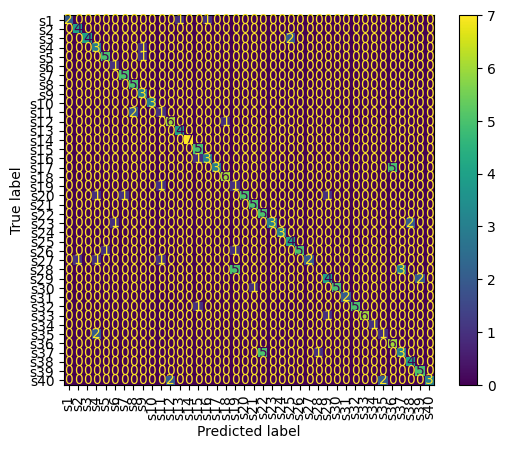

In [31]:
display_confusion_matrix(test_ids, test_predicted, display_labels=id2label)
plt.show()

There's probably a class or two that our model didn't do too well with.

#### Improving Our Model

How can we improve this model ? We picked $10$ components just to see what would happens with a dimensionality reduction factor of $1000$.

What happens if we use $20$ components? $20$ is still a lot less than $10\text{,}304$ and probably still easy for our `RandomForestClassifier` to handle.

How much of the data's variance is kept with $20$ components?

In [ ]:
## TODO: Re-run the classification training, but using 15, 20, 32 PCs



In [ ]:
test_ids = []

while len(set(test_ids)) != len(id2label):
  faces_train_df, faces_test_df = train_test_split(faces_df, test_size=0.5)
  test_ids = faces_test_df["id"]

In [ ]:
train_features = faces_train_df.drop(columns=["id"])
train_ids = faces_train_df["id"]

test_features = faces_test_df.drop(columns=["id"])
test_ids = faces_test_df["id"]

In [ ]:
face_model = RandomForestClassifier()

# Create a model that classifies faces based on principal components
face_model.fit(train_features, train_ids)

## 6. Run the model on the training data
train_predicted = face_model.predict(train_features)

## 7. Measure error
classification_error(train_ids, train_predicted)

In [ ]:
## 6. Run the model on the test data
test_predicted = face_model.predict(test_features)

## 7. Measure error
classification_error(test_ids, test_predicted)

### Interpretation 

In order to improve the classifier it might not be enough to just increase the number of components. It could be that this is as good as a `RandomForestClassifier` will do when given $10$ to $32$ Principal Component features.

Using all possible PC features ($400$), on the other hand, definitely makes our model worse.

### Conclusion

Unsupervised learning can be a very powerful and useful tool for performing exploratory data analysis and data pre-processing.

Because there's no labeled/correct answer in unsupervised learning, we can be a bit more subjective in how we pick our metrics for success.